# Example for Applying and Customizing Stain Normalisation

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/example_stainnorm.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/example_stainnorm.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

*Note*: This notebook assumes that `tiatoolbox` has already been installed. If it isn't, you can install it to your python environment by following guideline from https://github.com/TIA-Lab/tiatoolbox or using the cell below.

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools

In [ ]:
!pip install tiatoolbox

Welcome to tiatoolbox. This is an example on how to apply stain normalisation on image. We will

1. Load a sample whole slide image (WSI)
2. Extract a tile from the WSI
3. Stain-normalise the tile with various built-in methods in the libraries
4. Apply stain-normalisation with a user-defined stain matrix.

With the above, we will examine the `stainnorm` module of the library. For this notebook, we assume that you are familiar with the `wsireader` module, please check [here]() for their example usage if it's the otherwise.

We start by importing some related libraries.

In [1]:
import cv2
from tiatoolbox.dataloader.slide_info import slide_info
from tiatoolbox.dataloader import wsireader
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150 # for high resolution figure in notebook

Then, we will load a small WSI. This WSI is provided by the user using the path variable `user_sample_wsi_path`. By default, the value is `None` and the WSI will be downloaded from the web using the provided link instead. When downloading from the web, the WSI will be saved under `data_dir` with the named provided in `sample_file_name`. Additionally, data generated by the notebook will also be stored under `data_dir`. Users can change the `data_dir` to their preferred location.


In [2]:
data_dir = './tmp'
sample_file_name = 'sample_wsi_small.svs'

user_sample_wsi_path = None

def download(url_path, save_path):
    r = requests.get(url_path)
    with open(save_path, "wb") as f:
        f.write(r.content)
    return

user_sample_wsi_path = None

if user_sample_wsi_path is None:
    sample_wsi_path = '%s/%s' % (data_dir, sample_file_name)
else:
    sample_wsi_path = user_sample_wsi_path
if not os.path.exists(sample_wsi_path):
    os.makedirs(os.path.dirname(sample_wsi_path))
    url_path = "http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs"
    download(url_path, sample_wsi_path)

Next, we proceed with opening the downloaded WSI sample with `OpenSlideWSIReader` and plot its thumbnail to check for regions of interest. We will also print out its basic information.


('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', WindowsPath('tmp/sample_wsi_small.svs'))


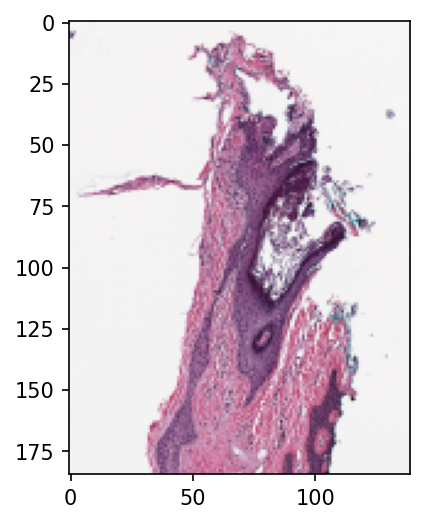

In [3]:
# create a file handler
wsi_reader = wsireader.get_wsireader(
                input_img=sample_wsi_path)
wsi_info = wsi_reader.info.as_dict()
# we will print out each info line by line
print(*list(wsi_info.items()), sep='\n')
wsi_thumb = wsi_reader.slide_thumbnail(resolution=1.25, units='power')

plt.imshow(wsi_thumb)
plt.show()


From the figure, around `50x50` at position `[50, 100]` (XY-coordinate) in the thumbnail contains both the stroma and the gland tissue component. This would be a nice sample for different staining method. The thumbnail is loaded at x1.25 objective power. We proceed to convert the position and size to `[800, 1600]` and `800x800` at x16 objective power and load the area up.

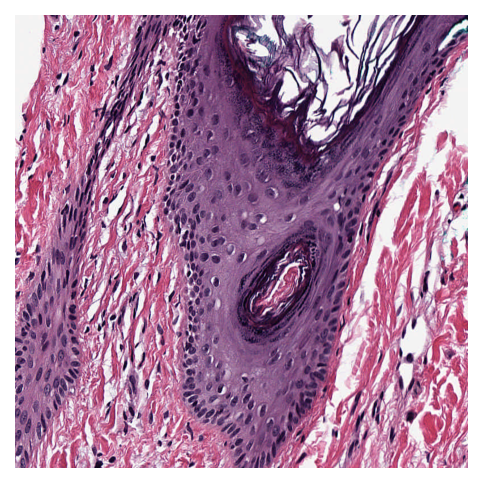

In [4]:
sample = wsi_reader.read_region(
            location=[800, 1600], # in X, Y
            level=0, size=[800, 800])
plt.imshow(sample)
plt.axis('off')
plt.show()


Now we will download a different image to act as target stain.

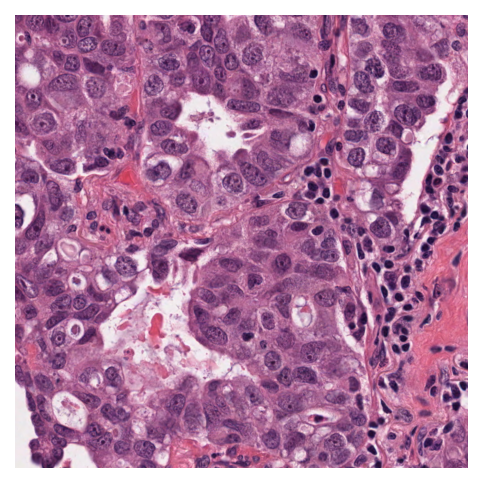

In [5]:
# downloading the target image
url_path = "https://raw.githubusercontent.com/TIA-Lab/tiatoolbox/develop/data/target_image.png"
target_image_path = '%s/stain_target.png' % (data_dir)
download(url_path, target_image_path)

target_image = cv2.imread(target_image_path)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
plt.imshow(target_image)
plt.axis('off')
plt.show()

We can stain-normalise the `sample` image to the target image using the widely known [Vahadane](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7460968) method. The normaliser follow the `sklearn` calling style and is applied as follows:

C:\tools\Anaconda3\envs\tiatoolbox_test\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


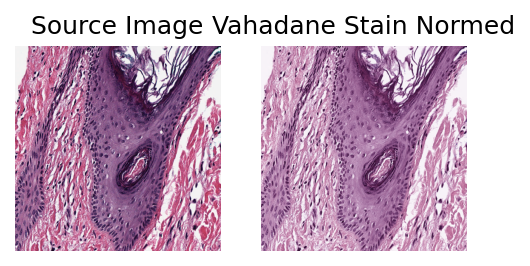

In [6]:
from tiatoolbox.tools import stainnorm

stain_normalizer = stainnorm.VahadaneNormaliser()
stain_normalizer.fit(target_image)

normed_sample = stain_normalizer.transform(sample.copy())

plt.subplot(1,3,1)
plt.imshow(target_image)
plt.title('Target Image')
plt.axis('off')
plt.subplot(1,3,1)
plt.imshow(sample)
plt.title('Source Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(normed_sample)
plt.title('Vahadane Stain Normed')
plt.axis('off')
plt.show()


At the moment, the library contains implementation for 4 stain-normalisation methods. You can either create them by using their class name like above, or our provided getter function `get_normaliser` by inputting the corresponding method name. Here, we will illustrate how you can use the latter approach to get the normaliser.

The stain normalisation names are provide in `method_name_list` variable below. We will sequentially apply each method on the `sample` image and plot them up for visual comparison.

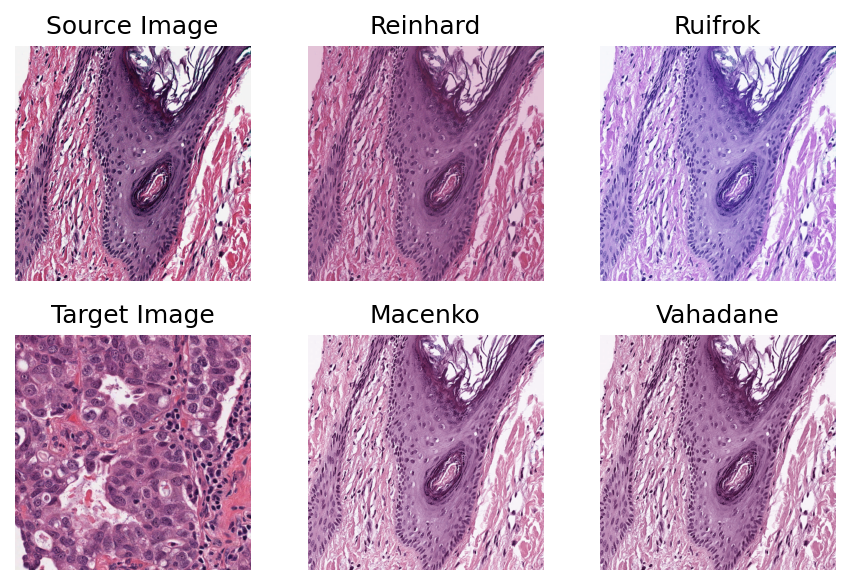

In [7]:
method_name_list = ['reinhard', 'ruifrok', 'macenko', 'vahadane']

plt.subplot(2,3,1)
plt.imshow(sample)
plt.title('Source Image')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(target_image)
plt.title('Target Image')
plt.axis('off')

pos = [2, 3, 5, 6]
for idx, method_name in enumerate(method_name_list):
    stain_normalizer = stainnorm.get_normaliser(method_name)
    stain_normalizer.fit(target_image)

    normed_sample = stain_normalizer.transform(sample.copy())
    plt.subplot(2,3,pos[idx])
    plt.imshow(normed_sample)
    plt.title(method_name.capitalize())
    plt.axis('off')
plt.tight_layout()
plt.show()

In addition to the 4 implemented methods, you can also extend the basic functionalities to implement your own method. One way is to subclass the base class `stainnorm.StainNormaliser` and implement your method. Another way is to provide your custom stain conversion matrix and input it to the `stainnorm.StainNormaliser`. Note, the former is for advanced users only! In this notebook, we will only explore the customisation of the input stain matrix. As an example, we will use the stain matrix in `skimage` library for getting Feulgen + Light Green stained from RGB. We will finally compare the stain-normalisation result using a custom defined stain matrix and using the Vahadane method.

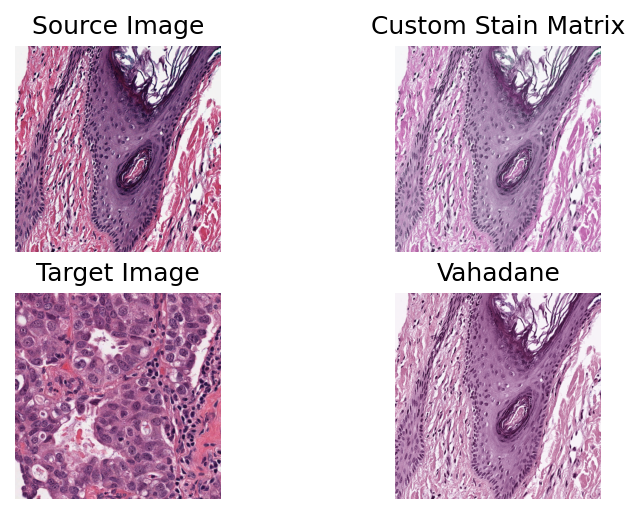

In [8]:

import skimage.color

stain_matrix = skimage.color.fgx_from_rgb[:2]
custom_normalizer = stainnorm.CustomNormaliser(stain_matrix)
custom_normalizer.fit(target_image)

vahadane_normalizer = stainnorm.VahadaneNormaliser()
vahadane_normalizer.fit(target_image)

normed_sample1 = custom_normalizer.transform(sample.copy())
normed_sample2 = stain_normalizer.transform(sample.copy())

plt.subplot(2,2,1)
plt.imshow(sample)
plt.title('Source Image')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(target_image)
plt.title('Target Image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(normed_sample1)
plt.title('Custom Stain Matrix')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(normed_sample2)
plt.title('Vahadane')
plt.axis('off')
plt.show()